In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 9.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [50]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# import pmdarima as pm
from datetime import timedelta
import numpy as np


In [12]:
df = pd.read_csv("time_series.csv", parse_dates=["ds"])
df = df.set_index("ds")
ts = df["n_posts_c"]

In [13]:
adf_res = adfuller(ts.dropna())
print(f"ADF p-value: {adf_res[1]:.4f}")

ADF p-value: 0.0122


In [16]:
best_aic = float("inf")
best_order = None

for p, d, q in itertools.product(range(3), [0,1], range(3)):
    try:
        m = ARIMA(ts, order=(p,d,q)).fit()
        if m.aic < best_aic:
            best_aic, best_order = m.aic, (p,d,q)
    except:
        continue

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Framewo

In [17]:
p, d, q = 1, 1, 1
model = ARIMA(ts, order=(p, d, q)).fit()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [18]:
pred = model.get_prediction(start=ts.index[0], end=ts.index[-1])
pred_mean = pred.predicted_mean
ci = pred.conf_int()
lower_ci = ci.iloc[:, 0]
upper_ci = ci.iloc[:, 1]

In [19]:
spikes = ts[ts > upper_ci]


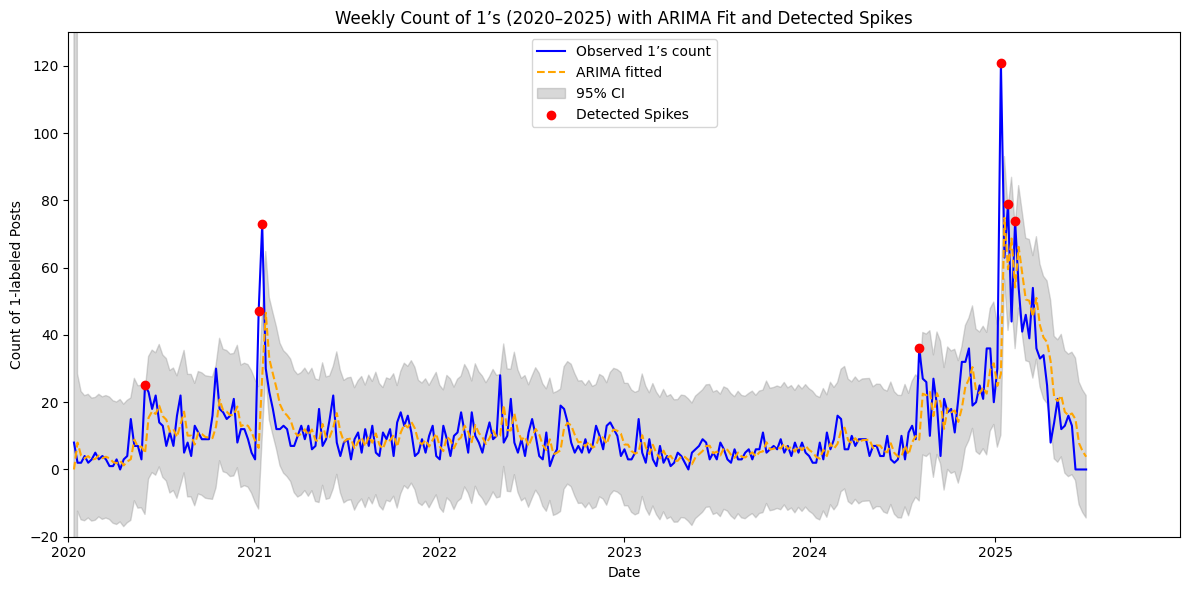

In [33]:
events = {
    "2020-06-28": "Protests near white House", 
    "2021-01-06": "US Capitol Riot",
    
    "2024-07-21": "Trump's assasination attempt",
    "2025-01-20": "US President's Inauguration",
}
# Convert keys to Timestamps
events = {pd.to_datetime(d): lab for d, lab in events.items()}

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Observed 1’s count", color="blue")
plt.plot(pred_mean, linestyle="--", label="ARIMA fitted", color="orange")
plt.fill_between(ts.index, lower_ci, upper_ci, color="gray", alpha=0.3, label="95% CI")
plt.scatter(spikes.index, spikes.values, marker="o", color="red", label="Detected Spikes", zorder=5)

# Limit x-axis to 2020-2025
plt.xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-12-31"))
plt.ylim(-20, 130)

plt.title("Weekly Count of 1’s (2020–2025) with ARIMA Fit and Detected Spikes")
plt.xlabel("Date")
plt.ylabel("Count of 1-labeled Posts")
plt.legend()
plt.tight_layout()
plt.show()

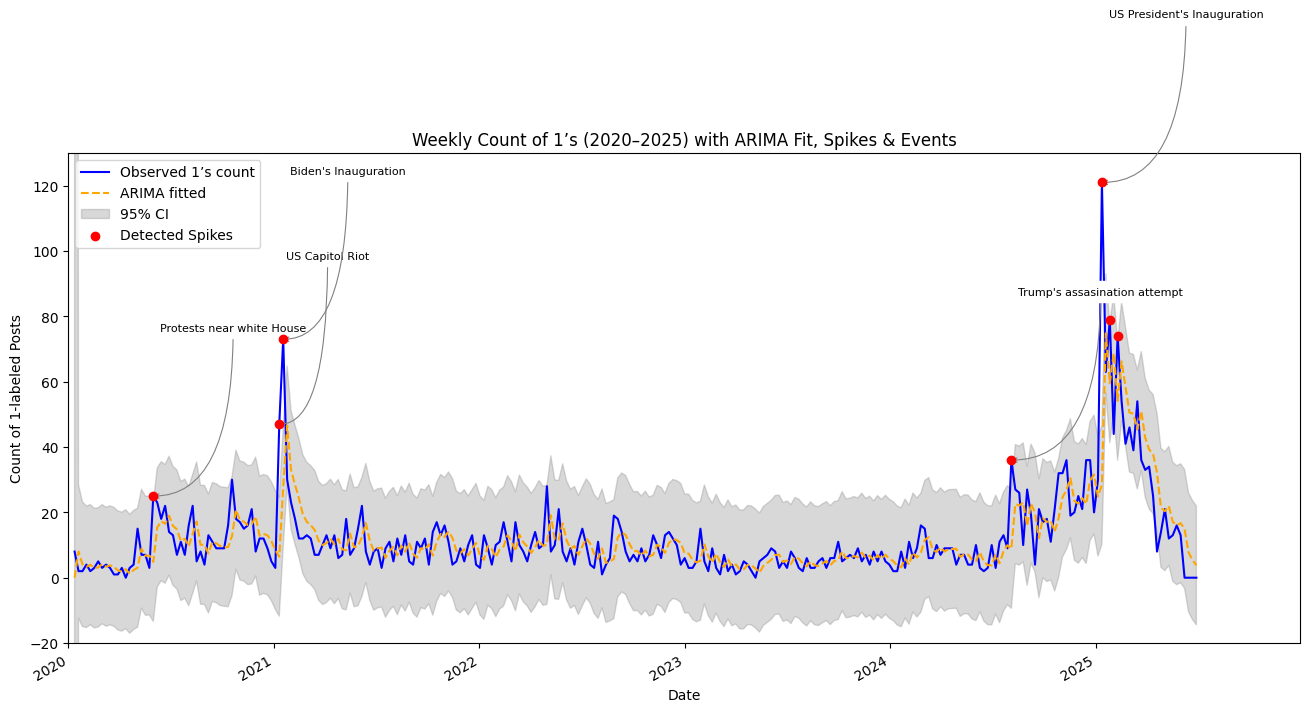

In [58]:
events = {
    "2020-06-28": "Protests near white House", 
    "2021-01-06": "US Capitol Riot",
    "2021-01-20": "Biden's Inauguration",
    "2024-07-21": "Trump's assasination attempt",
    "2025-01-19": "US President's Inauguration",
}

events = {pd.to_datetime(d): lab for d, lab in events.items()}

fig, ax = plt.subplots(figsize=(14, 7))

# 1) Plot your series
ax.plot(ts, label="Observed 1’s count", color="blue")
ax.plot(pred_mean, "--", label="ARIMA fitted", color="orange")
ax.fill_between(ts.index, lower_ci, upper_ci,
                color="gray", alpha=0.3, label="95% CI")
ax.scatter(spikes.index, spikes.values,
           marker="o", color="red", label="Detected Spikes", zorder=5)

ax.set_ylim(-20, 130)

# 2) Annotate events
for date, label in events.items():
    # 1) find the nearest spike date
    if spikes.empty:
        continue
    # compute absolute distance in days
    deltas = np.abs((spikes.index - date).to_numpy())    
    nearest_idx = deltas.argmin()
    spike_date = spikes.index[nearest_idx]
    y0 = spikes.iloc[nearest_idx]

    # 2) choose text position (tweak dx/dy as needed)
    text_dx = pd.Timedelta(days=12)
    text_dy = 50
    text_x = spike_date + text_dx
    text_y = y0 + text_dy

    # 3) annotate with an arrow pointing precisely to (spike_date, y0)
    ax.annotate(
        label,
        xy=(spike_date, y0),       # arrow tip at the actual red-circle
        xytext=(text_x, text_y),   # label text
        arrowprops=dict(
            arrowstyle="->",
            color="gray",
            lw=0.8,
            shrinkA=0,
            shrinkB=0,
            connectionstyle="angle3"
        ),
        fontsize=8,
        backgroundcolor="white",
        ha="left",
        va="bottom"
    )

# 4) Final touches
ax.set_xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-12-31"))
ax.set_title("Weekly Count of 1’s (2020–2025) with ARIMA Fit, Spikes & Events")
ax.set_xlabel("Date")
ax.set_ylabel("Count of 1-labeled Posts")
ax.legend(loc="upper left")

# rotate dates and adjust margins
fig.autofmt_xdate()
fig.subplots_adjust(left=0.07, right=0.95, bottom=0.18, top=0.88)

plt.savefig("arima_spikes_events.jpg", dpi=300, bbox_inches="tight")
plt.show()